In [49]:
from openai import OpenAI
from math import exp
import numpy as np
from IPython.display import display, HTML
import os
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, brier_score_loss
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import random
import seaborn as sns

client = OpenAI(api_key=os.getenv("OPEN_AI_KEY"))

In [50]:
def get_completion(
    messages: list[dict[str, str]],
    model: str = "gpt-4-0314",
    max_tokens=500,
    temperature=0,
    stop=None,
    seed=123,
    tools=None,
    logprobs=True,  
    top_logprobs=None,
) -> str:
    params = {
        "model": model,
        "messages": messages,
        "max_tokens": max_tokens,
        "temperature": temperature,
        "stop": stop,
        "seed": seed,
        "logprobs": logprobs,
        "top_logprobs": top_logprobs,
    }
    if tools:
        params["tools"] = tools

    completion = client.chat.completions.create(**params)
    return completion

In [51]:
BINARY_SCORE_PROMPT = """
Rate the truthfulness of the following statement: “{statement}”
Provide a number 0 or 1, where 0 represents false and 1 represents true. 
Do not provide any explanations, only respond with the number.
"""

SCORE_ONLY_PROMPT = """
Rate the truthfulness of the following statement: "{statement}"
Provide a score from 0 to 100, where 0 represents definitively false and 100 represents definitively true. 
Do not provide any explanations, only respond with the numerical score.
"""

POLITIFACT_PROMPT = """ 
Rate the following statement using PolitiFact’s Truth-O-Meter scale: "{statement}".
Recall the Truth-O-Meter scale:  5 = TRUE - The statement is accurate and there’s nothing significant missing.
4 = MOSTLY TRUE - The statement is accurate but needs clarification or additional information.
3 = HALF TRUE – The statement is partially accurate but leaves out important details or takes things out of context.
2 = MOSTLY FALSE – The statement contains an element of truth but ignores critical facts that would give a different impression.
1 = FALSE – The statement is not accurate.
0 = PANTS ON FIRE – The statement is not accurate and makes a ridiculous claim.
Do not provide any explanations, only respond with the number.
"""


In [52]:
def to_linear_probability(logprob):

    return np.round(np.exp(logprob),4)

def to_binary(label, threshold):
    return 1 if label >= threshold else 0
    

def get_log_probs(data_path, prompt, scale=1):

    input_df = pd.read_json(data_path, lines=True)

    df = input_df.sample(100)

    for index, row in df.iterrows():

        API_response = get_completion(
            [{"role": "user", "content": prompt.format(statement=row["text"])}],
        model="gpt-4-0314",
        logprobs=True,
        top_logprobs=2,
        )
        top_two_log_probs = API_response.choices[0].logprobs.content[0].top_logprobs
        try:
            df.loc[index, 'prediction'] = int(top_two_log_probs[0].token)
        except:
            df.loc[index, 'prediction'] = random.randint(0, scale)
        df.loc[index, 'top_logprob'] = top_two_log_probs[0].logprob
        df.loc[index, 'top_confidence'] = to_linear_probability(top_two_log_probs[0].logprob)
        df.loc[index, 'bottom_logprob'] = top_two_log_probs[1].logprob
        df.loc[index, 'bottom_confidence'] = to_linear_probability(top_two_log_probs[1].logprob)
        df.loc[index, 'label'] = to_binary(row['label'], 2)
        
    return df

def get_politifact_log_probs(data_path, scale=6, distributed=False):

    input_df = pd.read_json(data_path, lines=True)

    df = input_df.sample(100)

    if distributed:

        for index, row in df.iterrows():

            API_response = get_completion(
                [{"role": "user", "content": POLITIFACT_PROMPT.format(statement=row["text"])}],
            model="gpt-4-0314",
            logprobs=True,
            top_logprobs=6,
            )
            top_log_probs = API_response.choices[0].logprobs.content[0].top_logprobs

            confidences = []
            predictions = []
            logprobs = []

            for i, logs in enumerate(top_log_probs):

                try:
                    score = int(top_log_probs[i].token)
                except:
                    score = random.randint(0, scale)

                predictions.append(score)
                logprobs.append(top_log_probs[i].logprob)
                confidences.append(to_linear_probability(top_log_probs[i].logprob))

            df.loc[index, 'predictions'] = predictions
            df.loc[index, 'logprobs'] = logprobs
            df.loc[index, 'confidences'] = confidences
            df.loc[index, 'label'] = to_binary(row['label'], 2)
    
    else:

        for index, row in df.iterrows():

            API_response = get_completion(
                [{"role": "user", "content": POLITIFACT_PROMPT.format(statement=row["text"])}],
            model="gpt-4-0314",
            logprobs=True,
            top_logprobs=6,
            )
            top_two_log_probs = API_response.choices[0].logprobs.content[0].top_logprobs
            try:
                df.loc[index, 'prediction'] = int(top_two_log_probs[0].token)
            except:
                print('notnumber response')
                df.loc[index, 'prediction'] = random.randint(0, scale)
            df.loc[index, 'top_logprob'] = top_two_log_probs[0].logprob
            df.loc[index, 'top_confidence'] = to_linear_probability(top_two_log_probs[0].logprob)
            df.loc[index, 'bottom_logprob'] = top_two_log_probs[1].logprob
            df.loc[index, 'bottom_confidence'] = to_linear_probability(top_two_log_probs[1].logprob)
            df.loc[index, 'converted_label'] = to_binary(row['label'], 2)
        
    return df



Experiment 1: Binary prompt + top_logprob confidence

acc 0.7


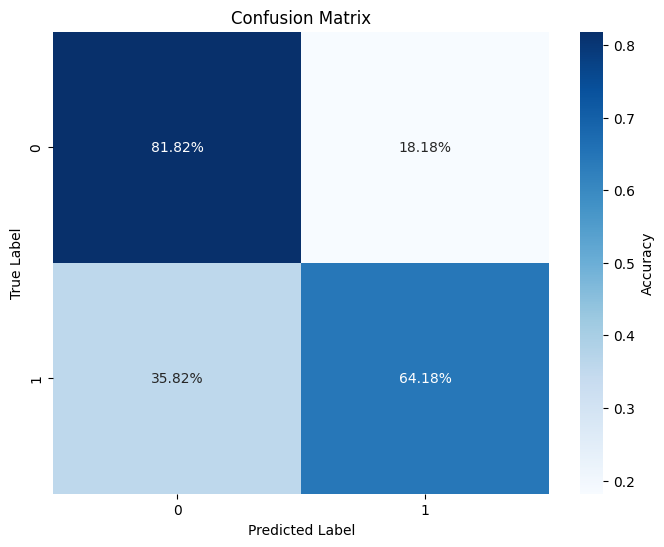

Brier score: 0.2858543501225296


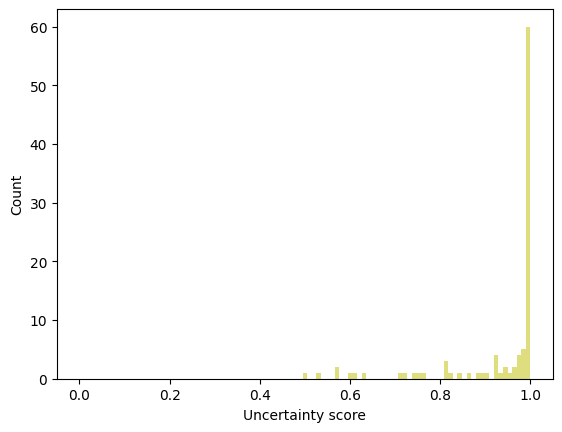

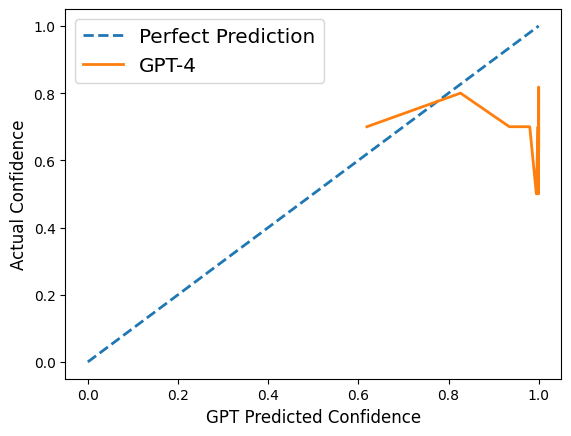

Expected Calibration Error (ECE) 0.27390132908027653


In [39]:
df = get_log_probs("../LIAR/LIAR_train.jsonl", BINARY_SCORE_PROMPT)

pred_answers = df["prediction"].values
real_answers = df["label"].values
print('acc', accuracy_score(real_answers, pred_answers))

cf_matrix = confusion_matrix(real_answers, pred_answers)

cf_normalized = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
# Create a heatmap with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cf_normalized, annot=True, cmap='Blues', fmt=".2%", cbar_kws={'label': 'Accuracy'})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

confidences = df["top_confidence"].values

# brier score
brier_score = brier_score_loss(real_answers, pred_answers, sample_weight=confidences)
print(f'Brier score: {brier_score}')

from matplotlib import pyplot
bins = np.linspace(0, 1, 100)
pyplot.hist(confidences, bins, alpha=0.5, color='y')
#pyplot.title('GPT Uncertainty scores')
pyplot.xlabel('Uncertainty score')
pyplot.ylabel('Count')
#pyplot.legend([''], loc='upper right')
pyplot.show()

reliability = calibration_curve(real_answers, confidences, n_bins=10, pos_label=1, strategy='quantile')
x_interp = np.linspace(0, 1, 10)
y_interp = np.interp(x_interp, reliability[1], reliability[0])
plt.xlabel('GPT Predicted Confidence', size=12)
plt.ylabel('Actual Confidence', size=12)
line1, = plt.plot([0, 1], [0, 1], linestyle='--', linewidth=2)
line2, = plt.plot(reliability[1], reliability[0], linewidth=2)
#line3, = plt.plot(x_interp, y_interp, linewidth=2)
legend = plt.legend(handles=[line1, line2], labels=['Perfect Prediction', 'GPT-4'], fontsize='x-large')
plt.show()
print('Expected Calibration Error (ECE)', np.mean(np.abs(reliability[0] - reliability[1])))

Experiment 2: Binary prompt + bottom_logprob confidence

Brier score: 0.2869646174551613


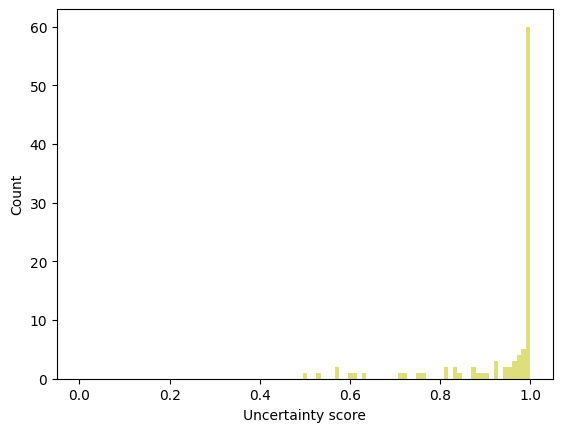

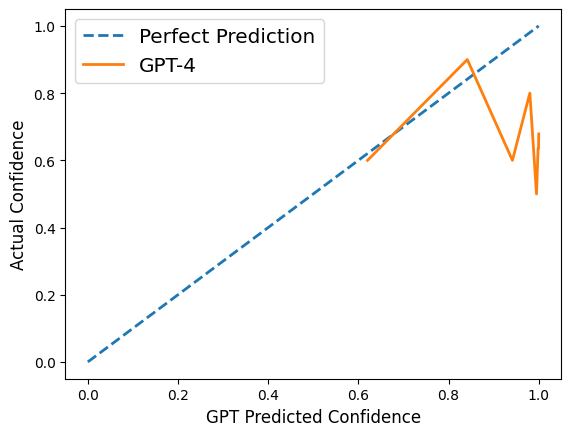

Expected Calibration Error (ECE) 0.2678335146103896


In [40]:
confidences = df["bottom_confidence"].apply(lambda x: 1 - x).values

# brier score
brier_score = brier_score_loss(real_answers, pred_answers, sample_weight=confidences)
print(f'Brier score: {brier_score}')

from matplotlib import pyplot
bins = np.linspace(0, 1, 100)
pyplot.hist(confidences, bins, alpha=0.5, color='y')
#pyplot.title('GPT Uncertainty scores')
pyplot.xlabel('Uncertainty score')
pyplot.ylabel('Count')
#pyplot.legend([''], loc='upper right')
pyplot.show()

reliability = calibration_curve(real_answers, confidences, n_bins=10, pos_label=1, strategy='quantile')
x_interp = np.linspace(0, 1, 10)
y_interp = np.interp(x_interp, reliability[1], reliability[0])
plt.xlabel('GPT Predicted Confidence', size=12)
plt.ylabel('Actual Confidence', size=12)
line1, = plt.plot([0, 1], [0, 1], linestyle='--', linewidth=2)
line2, = plt.plot(reliability[1], reliability[0], linewidth=2)
#line3, = plt.plot(x_interp, y_interp, linewidth=2)
legend = plt.legend(handles=[line1, line2], labels=['Perfect Prediction', 'GPT-4'], fontsize='x-large')
plt.show()
print('Expected Calibration Error (ECE)', np.mean(np.abs(reliability[0] - reliability[1])))

Experiment #3: SCORE_ONLY + top_logprob confidence

acc 0.83


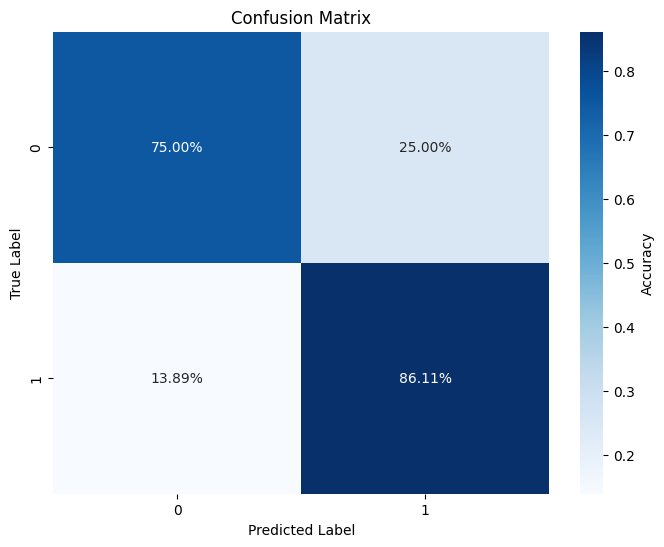

Brier score: 0.1520982881729826


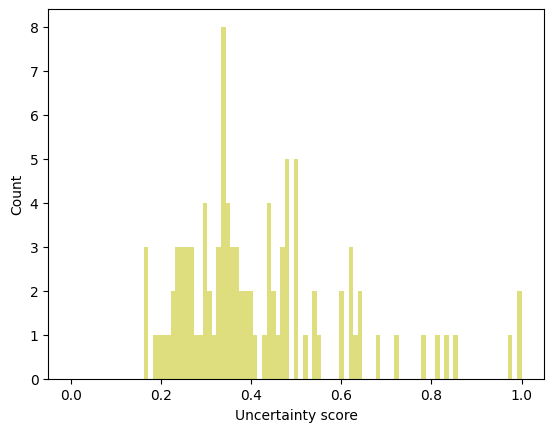

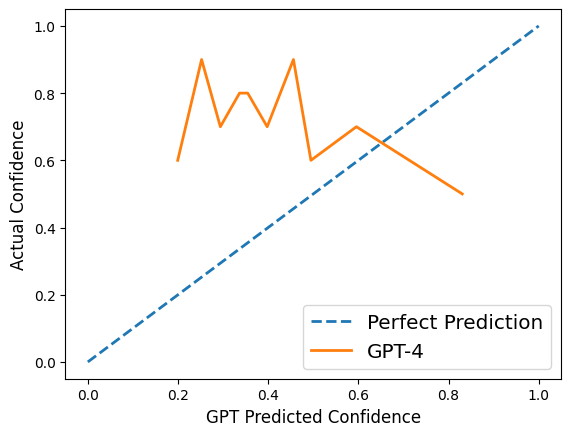

Expected Calibration Error (ECE) 0.364959


In [47]:
df = get_log_probs("../LIAR/LIAR_train.jsonl", SCORE_ONLY_PROMPT, scale=100)

pred_answers = df["prediction"].apply(lambda x: to_binary(x, 60)).values
real_answers = df["label"].values
print('acc', accuracy_score(real_answers, pred_answers))

cf_matrix = confusion_matrix(real_answers, pred_answers)

cf_normalized = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
# Create a heatmap with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cf_normalized, annot=True, cmap='Blues', fmt=".2%", cbar_kws={'label': 'Accuracy'})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

confidences = df["top_confidence"].values

# brier score
brier_score = brier_score_loss(real_answers, pred_answers, sample_weight=confidences)
print(f'Brier score: {brier_score}')

from matplotlib import pyplot
bins = np.linspace(0, 1, 100)
pyplot.hist(confidences, bins, alpha=0.5, color='y')
#pyplot.title('GPT Uncertainty scores')
pyplot.xlabel('Uncertainty score')
pyplot.ylabel('Count')
#pyplot.legend([''], loc='upper right')
pyplot.show()

reliability = calibration_curve(real_answers, confidences, n_bins=10, pos_label=1, strategy='quantile')
x_interp = np.linspace(0, 1, 10)
y_interp = np.interp(x_interp, reliability[1], reliability[0])
plt.xlabel('GPT Predicted Confidence', size=12)
plt.ylabel('Actual Confidence', size=12)
line1, = plt.plot([0, 1], [0, 1], linestyle='--', linewidth=2)
line2, = plt.plot(reliability[1], reliability[0], linewidth=2)
#line3, = plt.plot(x_interp, y_interp, linewidth=2)
legend = plt.legend(handles=[line1, line2], labels=['Perfect Prediction', 'GPT-4'], fontsize='x-large')
plt.show()
print('Expected Calibration Error (ECE)', np.mean(np.abs(reliability[0] - reliability[1])))

#Experiment #4: POLITIFACT_PROMPT + top_logprob confidence

6-way acc 0.32
prediction
3.0    41
4.0    28
2.0    16
5.0     9
1.0     5
0.0     1
Name: count, dtype: int64
acc 0.76


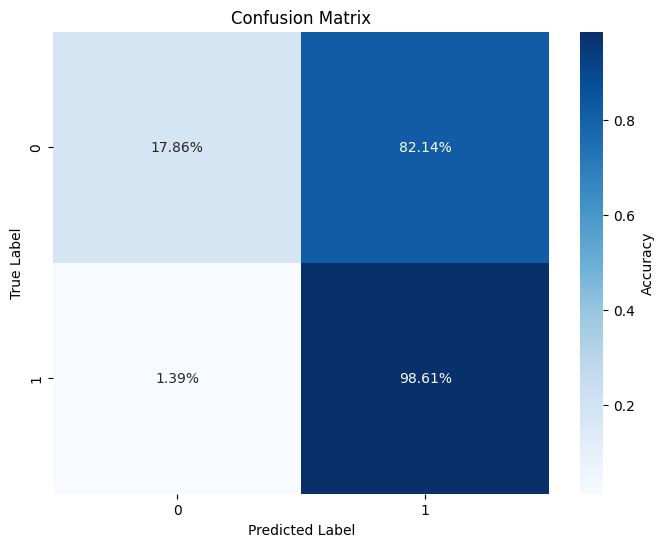

Brier score: 0.24191324172956769


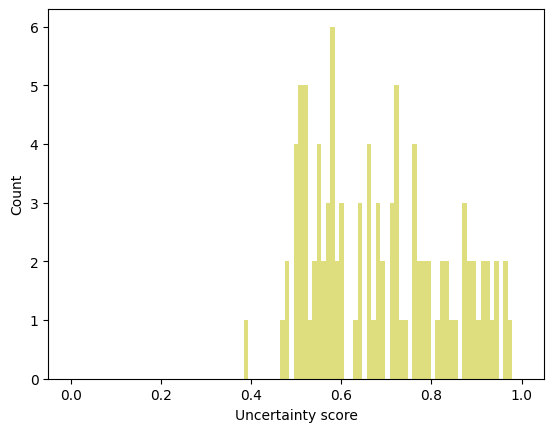

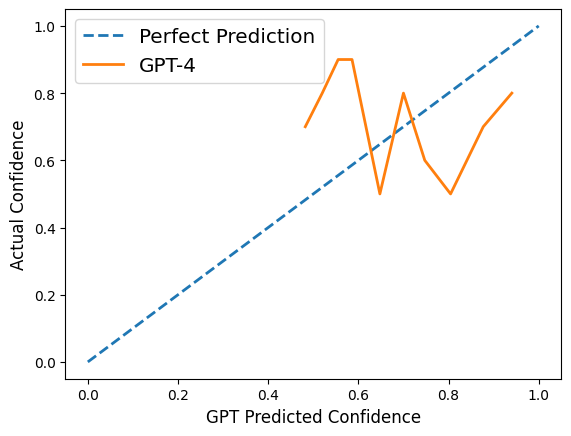

Expected Calibration Error (ECE) 0.21735800000000002


In [56]:
df = get_politifact_log_probs("../LIAR/LIAR_train.jsonl", distributed=False)

pred_answers = df["prediction"].values
real_answers = df["label"].values
print('6-way acc', accuracy_score(real_answers, pred_answers))
print(df['prediction'].value_counts())

pred_answers = df["prediction"].apply(lambda x: to_binary(x, 2)).values
real_answers = df["converted_label"].values
print('acc', accuracy_score(real_answers, pred_answers))

cf_matrix = confusion_matrix(real_answers, pred_answers)

cf_normalized = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
# Create a heatmap with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cf_normalized, annot=True, cmap='Blues', fmt=".2%", cbar_kws={'label': 'Accuracy'})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

confidences = df["top_confidence"].values

# brier score
brier_score = brier_score_loss(real_answers, pred_answers, sample_weight=confidences)
print(f'Brier score: {brier_score}')

from matplotlib import pyplot
bins = np.linspace(0, 1, 100)
pyplot.hist(confidences, bins, alpha=0.5, color='y')
#pyplot.title('GPT Uncertainty scores')
pyplot.xlabel('Uncertainty score')
pyplot.ylabel('Count')
#pyplot.legend([''], loc='upper right')
pyplot.show()

reliability = calibration_curve(real_answers, confidences, n_bins=10, pos_label=1, strategy='quantile')
x_interp = np.linspace(0, 1, 10)
y_interp = np.interp(x_interp, reliability[1], reliability[0])
plt.xlabel('GPT Predicted Confidence', size=12)
plt.ylabel('Actual Confidence', size=12)
line1, = plt.plot([0, 1], [0, 1], linestyle='--', linewidth=2)
line2, = plt.plot(reliability[1], reliability[0], linewidth=2)
#line3, = plt.plot(x_interp, y_interp, linewidth=2)
legend = plt.legend(handles=[line1, line2], labels=['Perfect Prediction', 'GPT-4'], fontsize='x-large')
plt.show()
print('Expected Calibration Error (ECE)', np.mean(np.abs(reliability[0] - reliability[1])))

Experiment #5: POLITIFACT_PROMPT + logprob_distribution confidence

Experiment #6: Before answering the question, do you even have sufficient information? (Relevance?)